In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
%load_ext nb_black

2022-04-01 19:52:20,816 - blib2to3.pgen2.driver - INFO - Generating grammar tables from /opt/anaconda3/envs/transmilenio/lib/python3.8/site-packages/blib2to3/Grammar.txt
2022-04-01 19:52:20,825 - blib2to3.pgen2.driver - INFO - Writing grammar tables to /Users/juanazuero/Library/Caches/black/22.1.0/Grammar3.8.0.final.0.pickle
2022-04-01 19:52:20,826 - blib2to3.pgen2.driver - INFO - Writing failed: [Errno 2] No such file or directory: '/Users/juanazuero/Library/Caches/black/22.1.0/tmplzrxvpv5'
2022-04-01 19:52:20,826 - blib2to3.pgen2.driver - INFO - Generating grammar tables from /opt/anaconda3/envs/transmilenio/lib/python3.8/site-packages/blib2to3/PatternGrammar.txt
2022-04-01 19:52:20,827 - blib2to3.pgen2.driver - INFO - Writing grammar tables to /Users/juanazuero/Library/Caches/black/22.1.0/PatternGrammar3.8.0.final.0.pickle
2022-04-01 19:52:20,827 - blib2to3.pgen2.driver - INFO - Writing failed: [Errno 2] No such file or directory: '/Users/juanazuero/Library/Caches/black/22.1.0/tmp52

<IPython.core.display.Javascript object>

In [4]:
validaciones_troncal_summary = catalog.load("validaciones_troncal_summary@pandas")

2022-04-01 19:53:04,114 - kedro.io.data_catalog - INFO - Loading data from `validaciones_troncal_summary@pandas` (ParquetDataSet)...


<IPython.core.display.Javascript object>

In [6]:
dic_estacion_linea = catalog.load("dic_estacion_linea_int")

2022-04-01 19:54:00,270 - kedro.io.data_catalog - INFO - Loading data from `dic_estacion_linea_int` (JSONDataSet)...


<IPython.core.display.Javascript object>

In [20]:
stations = set(dic_estacion_linea.keys()).union(
    set(
        [
            c
            for c in validaciones_troncal_summary["Estación"].unique()
            if len(c.split(")")[0]) == 6
        ]
    )
)

<IPython.core.display.Javascript object>

In [26]:
demanda_dia = (
    validaciones_troncal_summary[
        validaciones_troncal_summary["Estación"].isin(stations)
    ]
    .groupby("date")
    .sum()
)

<IPython.core.display.Javascript object>

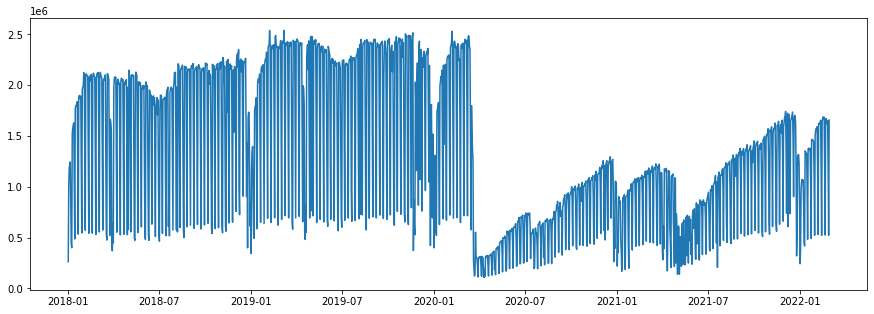

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots()
ax.plot(demanda_dia)
fig.set_size_inches(15, 5)

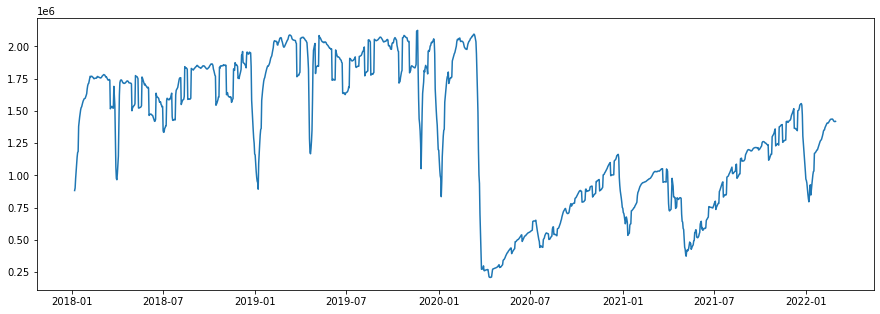

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots()
ax.plot(demanda_dia.rolling(7).mean())
fig.set_size_inches(15, 5)

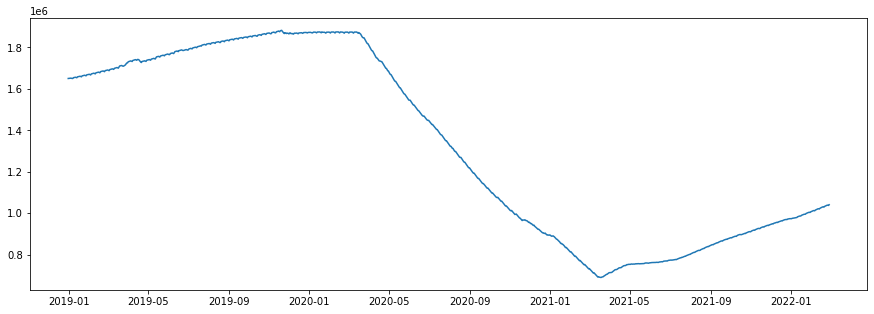

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots()
ax.plot(demanda_dia.rolling(365).mean())
fig.set_size_inches(15, 5)

In [21]:
stations

{'(02000) Cabecera Autopista Norte',
 '(02001) Centro Comercial Santa Fe',
 '(02101) Toberín',
 '(02102) Calle 161',
 '(02102) Cardio Infantíl',
 '(02103) Mazurén',
 '(02104) Calle 146',
 '(02105) Calle 142',
 '(02200) Alcalá',
 '(02201) Prado',
 '(02202) Calle 127',
 '(02204) Pepe Sierra',
 '(02205) Calle 106',
 '(02300) Calle 100',
 '(02302) Virrey',
 '(02303) Calle 85',
 '(02304) Heroes',
 '(02502) Terminal',
 '(03000) Portal Suba',
 '(03001) LA CAMPIÑA',
 '(03002) SUBA - TV- 91',
 '(03003) 21 ANGELES',
 '(03004) GRATAMIRA',
 '(03005) SUBA - AV. BOYACA',
 '(03006) NIZA - CALLE 127',
 '(03007) HUMEDAL CORDOBA',
 '(03009) Av. Suba- Calle 116',
 '(03009) SHAIO',
 '(03010) PUENTE LARGO',
 '(03011) SUBA - CALLE 100',
 '(03012) SUBA - CALLE 95',
 '(03013) RIO NEGRO',
 '(03014) SAN MARTIN',
 '(04000) Cabecera Calle 80',
 '(04001) Quirigua',
 '(04002) Carrera 90',
 '(04003) Avenida Ciudad de Cali',
 '(04004) La Granja',
 '(04100) Carrera 77',
 '(04101) Minuto de Dios',
 '(04102) Avenida Boy

<IPython.core.display.Javascript object>

['(02000) Cabecera Autopista Norte',
 '(02001) Centro Comercial Santa Fe',
 '(02101) Toberín',
 '(02102) Calle 161',
 '(02103) Mazurén',
 '(02104) Calle 146',
 '(02105) Calle 142',
 '(02200) Alcalá',
 '(02201) Prado',
 '(02202) Calle 127',
 '(02205) Calle 106',
 '(02300) Calle 100',
 '(02302) Virrey',
 '(02303) Calle 85',
 '(02304) Heroes',
 '(02502) Terminal',
 '(03000) Portal Suba',
 '(03001) LA CAMPIÑA',
 '(03002) SUBA - TV- 91',
 '(03003) 21 ANGELES',
 '(03004) GRATAMIRA',
 '(03005) SUBA - AV. BOYACA',
 '(03006) NIZA - CALLE 127',
 '(03007) HUMEDAL CORDOBA',
 '(03009) Av. Suba- Calle 116',
 '(03010) PUENTE LARGO',
 '(03011) SUBA - CALLE 100',
 '(03012) SUBA - CALLE 95',
 '(03013) RIO NEGRO',
 '(03014) SAN MARTIN',
 '(04000) Cabecera Calle 80',
 '(04001) Quirigua',
 '(04002) Carrera 90',
 '(04003) Avenida Ciudad de Cali',
 '(04004) La Granja',
 '(04100) Carrera 77',
 '(04101) Minuto de Dios',
 '(04102) Avenida Boyaca',
 '(04103) Las Ferias',
 '(04104) Avenida 68',
 '(04105) Carrera 

<IPython.core.display.Javascript object>

In [19]:
[
    c
    for c in validaciones_troncal_summary["Estación"].unique()
    if c not in stations and len(c.split(")")[0]) < 6
]

['(1245) M84 Normal',
 '(1413) M82-L82 Ciclov',
 '(1414) M82 Refuerzo',
 '(1442) M86-K86 Normal',
 '(1444) M86-K86 Circular Aeropuerto',
 '(1446) M86-K86 Ciclov',
 '(1451) M82-L82 Normal',
 '(1452) L82 Refuerzo calle 79',
 '(1711) D81 Normal',
 '(1712) M81 Normal',
 '(1713) D81 Ciclov',
 '(1714) M81 Ciclov',
 '(1746) H83',
 '(1951) M83',
 '(1993) M84 Normal',
 '(1993) M84_Normal',
 '(1994) C84 Normal',
 '(1994) C84_Normal',
 '(2008) M84 Normal',
 '(2009) C84 Normal',
 '(2010) M84 Ciclovia',
 '(2011) C84 Ciclovia',
 '(1246) C84 Normal',
 '(1247) M84 Ciclov',
 '(1248) C84 Ciclovia',
 '(1443) K86 Refuerzo Calle 75',
 '(1445) M86-K86 Circular Portal-Museo',
 '(1450) M86-K86 Ciclovia Hasta T-3A',
 '(1995) M84_Ciclovia',
 '(1996) C84_Ciclovia',
 '(1249) Circular M84-C84',
 '(1448) M86-K86 Ciclov�desde CL118',
 '(1715) Circular CL72',
 '(1415) M82 Refuerzo Ciclov',
 '(1747) M83',
 '(1447) M86-K86 Ciclov�desde T-3A',
 '(1449) M86-K86 Ciclov�hasta CL118',
 '(790) Ida_Suba_Norte',
 '(1751) M86-K

<IPython.core.display.Javascript object>